# Data exploration and cleanup

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("/Users/antonis/code/Ant-mel/legendary_game_recs/")
from preprocessing.preprocess_1_cleaning import *
from preprocessing.preprocess_2_features import *

from sklearn.preprocessing import MultiLabelBinarizer


# Exploring the data

Data had to be scraped in small batches else it failed. 

When scraped during the day, batches would only be 10k as it would crash sooner and the person scraping could take brakes inbetween for whatever reason. 

For reference - a 10k batch would take 2.5 hours

In [2]:
set_1 = pd.read_csv('../raw_data/final_scrape_0to10k')
set_2 = pd.read_csv('../raw_data/final_scrape_10kto40k')
set_3 = pd.read_csv('../raw_data/final_scrape_40kto50k')
set_4 = pd.read_csv('../raw_data/final_scrape_50kto60k')
set_5 = pd.read_csv('../raw_data/final_scrape_60kto70k')
set_6 = pd.read_csv('../raw_data/final_scrape_70kto80k')
set_7 = pd.read_csv('../raw_data/final_scrape_80kto90k')
set_8 = pd.read_csv('../raw_data/final_scrape_90kto120k')


In [3]:
data = pd.concat((set_1, set_2, set_3, set_4, set_5, set_6, set_7, set_8))


In [4]:
data.shape


(111951, 27)

In [5]:
data.head()


,title,release_date,plays,playing,backlogs,wishlist,developers,avg_review,genres,platforms,...,ratings_one_five,ratings_two_zero,ratings_two_five,ratings_three_zero,ratings_three_five,ratings_four_zero,ratings_four_five,ratings_five_zero,url,game_id
0,PilotXross,2030-12-20,1,0,2,2,['PilotXross'],0.0,"['Indie', 'Racing', 'Sport']",['SteamVR'],...,0,0,0,0,0,0,0,0,/games/pilotxross/,123757
1,Plague Hunter,2029-02-07,0,0,2,7,[],0.0,"['Adventure', 'Indie']",['Windows PC'],...,0,0,0,0,0,0,0,0,/games/plague-hunter/,106694
2,The God Slayer,2027-12-31,1,0,1,11,['Pathea Games'],0.0,['RPG'],['PlayStation 5'],...,0,0,0,0,0,0,0,0,/games/the-god-slayer/,259874
3,Rise of Rebellion,2025-12-31,0,0,0,2,['KODANSHA'],0.0,['Adventure'],['Windows PC'],...,0,0,0,0,0,0,0,0,/games/rise-of-rebellion/,211568
4,Penny Blood,2025-12-31,1,0,27,124,[],0.0,['RPG'],"['Windows PC', 'PlayStation 5', 'Xbox Series']",...,0,0,0,0,0,0,0,0,/games/penny-blood/,214912


### Dealing with Duplicates

10,000 duplicates!!!

In [6]:
# Copying data before adjusting
working_data = data.copy()


In [7]:
working_data[['title', 'release_date']].duplicated().sum()


859

In [8]:
working_data.drop_duplicates(subset=['title'],inplace=True)


In [9]:
working_data[['title']].duplicated().sum()


0

### Incorrect dtypes

- release_date - Needs to be a datetime, but not important for the model, only important for the front-end
- developers, genres, platforms - change to lists (Currently they are strings that look like lists)
- plays, platying, backlogs, wishlists, total_reviews_total_lists - 'k' needs to be removed to make them all int


In [10]:
# Adjusting 'fake' lists to real lists
string_to_list_colums = ['developers','genres','platforms']
working_data[string_to_list_colums] = make_list_columns_to_lists(working_data, string_to_list_colums)


In [11]:
# Turning numeric object columns into int
numeric_columns = ['plays','playing','backlogs','wishlist','total_reviews','total_lists']

for col in numeric_columns:
    numeric_objects_reformatted(working_data, col)


#### Removing games with release date 0001-01-01

In [12]:
year_1_mask = working_data['release_date'] == '0001-01-01'


In [13]:
games_that_exist = working_data[~year_1_mask]


In [14]:
games_that_exist.shape


(106701, 27)

## Dealing with non-main games

DLC, expansions and mods should not be part of the video game recomendations (but perhaps something we can do in future❓)

In [15]:
# removing main games and dropping categories column
# as its no longer useful

only_main_games = only_main_games(games_that_exist)


In [16]:
only_main_games.shape


(93321, 26)

### Cleaning our y

avg_reviews is currently our y

In the dataset, 64404 games do not have an avg_review, which means they have been reviewd less than 3 times. 

We are happy to remove these games as we choose not to recommend games that we assume have not been played buy humans.

In [17]:
main_games_dattime = change_to_datetype(only_main_games, 'release_date')


We need to seperate upcoming games so we can make recommend them to users - these would otherwise be removed as they cannot have reviews, and we drop games with a review score of 0

note: Review scores cannot be zero as the lowers review is 0.5

In [18]:
upcoming_mask = main_games_dattime['release_date'] > pd.Timestamp(datetime.date.today())
upcoming_games = main_games_dattime[upcoming_mask]
release_games = main_games_dattime[~upcoming_mask]


In [19]:
games_that_exist_with_reviews = remove_no_reviews(release_games)
games_that_exist_with_reviews.shape


(37155, 26)

### Creating final dataset

In [20]:
final_data = pd.concat((upcoming_games, games_that_exist_with_reviews))


## Visualising the data

### Numeric Data

Text(0.5, 1.0, 'Games released per year')

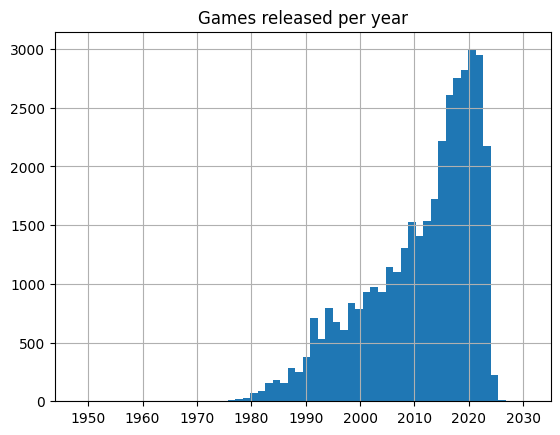

In [21]:
final_data['release_date'].hist(bins=60)
plt.title("Games released per year")


Text(0.5, 1.0, 'Distribution of avg_review scores')

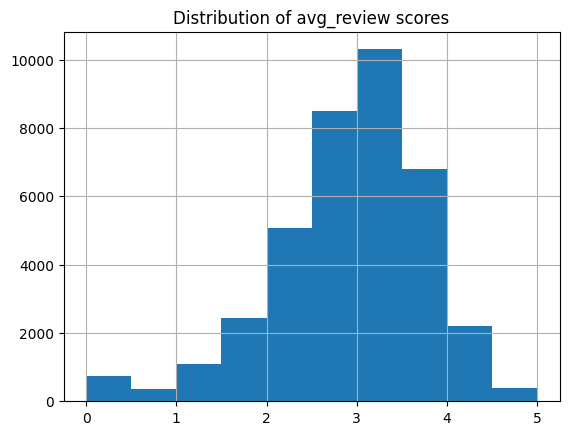

In [22]:
final_data['avg_review'].hist()
plt.title('Distribution of avg_review scores')


Text(0.5, 1.0, 'Total Reviews')

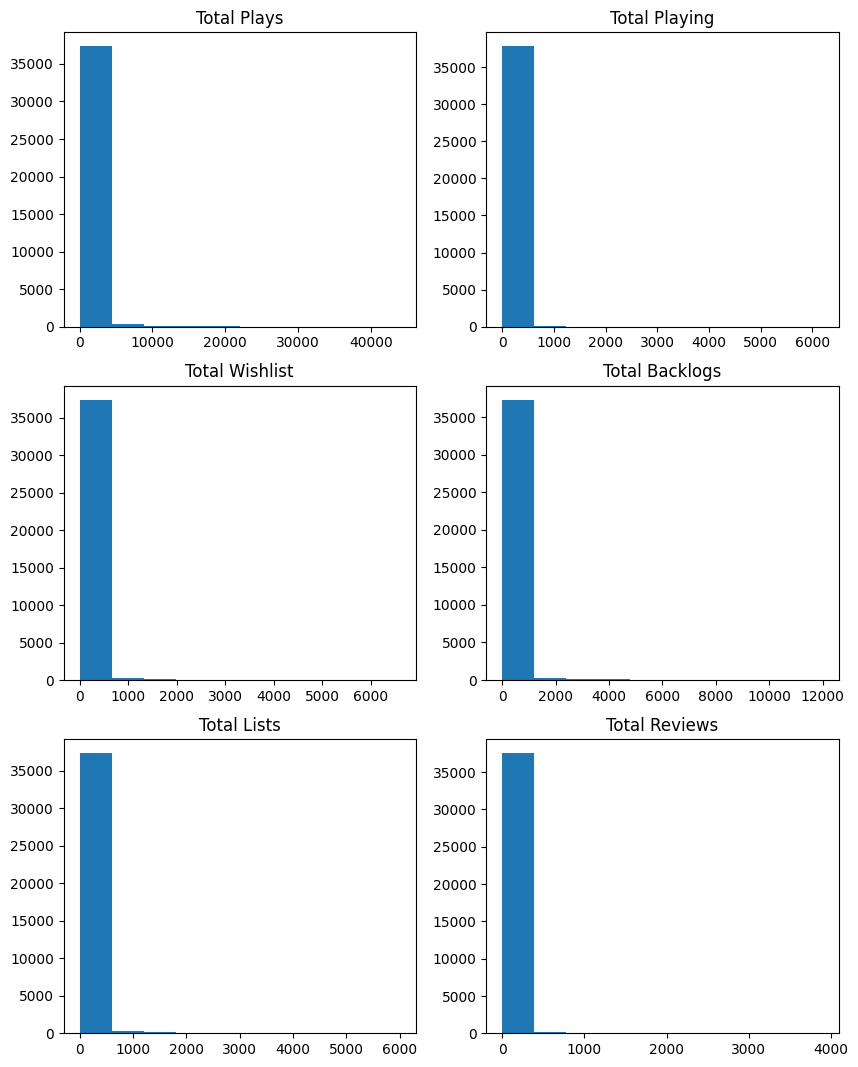

In [23]:
#Visualising numeric features
fig, axs = plt.subplots(3,2, figsize=(10, 13))

axs[0,0].hist(final_data['plays'])
axs[0,0].set_title('Total Plays')

axs[0,1].hist(final_data['playing'])
axs[0,1].set_title('Total Playing')

axs[1,0].hist(final_data['wishlist'])
axs[1,0].set_title('Total Wishlist')

axs[1,1].hist(final_data['backlogs'])
axs[1,1].set_title('Total Backlogs')

axs[2,0].hist(final_data['total_lists'])
axs[2,0].set_title('Total Lists')

axs[2,1].hist(final_data['total_reviews'])
axs[2,1].set_title('Total Reviews')


There are many games that have a 0 value or near 0 value, with few having values in the thousands. 

This will skew the model, and bias it towards popular games

Best option will be to use Yeo-Johnson Scaling - but they all look the same. How correlated are they?

Text(0.5, 1.0, '5')

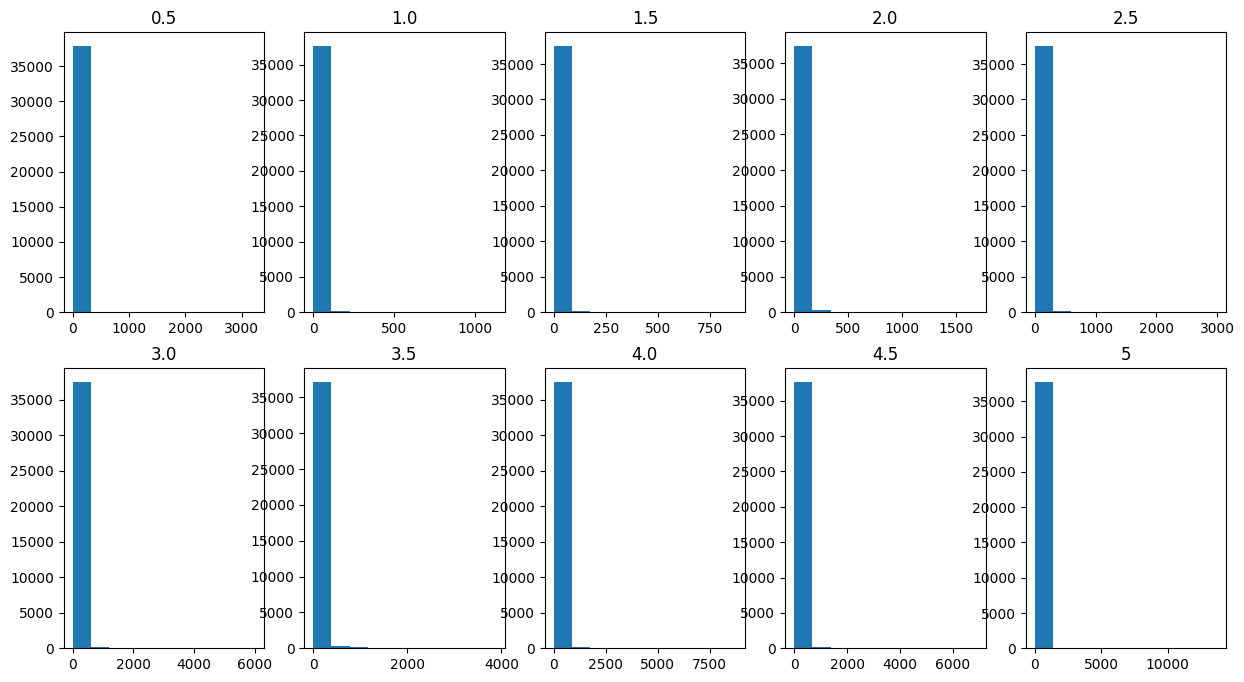

In [24]:
# Graphing the ratings_ columns

fig, axs = plt.subplots(2, 5, figsize=(15, 8))

axs[0,0].hist(final_data['ratings_zero_five'])
axs[0,0].set_title('0.5')

axs[0,1].hist(final_data['ratings_one_zero'])
axs[0,1].set_title('1.0')

axs[0,2].hist(final_data['ratings_one_five'])
axs[0,2].set_title('1.5')

axs[0,3].hist(final_data['ratings_two_zero'])
axs[0,3].set_title('2.0')

axs[0,4].hist(final_data['ratings_two_five'])
axs[0,4].set_title('2.5')

axs[1,0].hist(final_data['ratings_three_zero'])
axs[1,0].set_title('3.0')

axs[1,1].hist(final_data['ratings_three_five'])
axs[1,1].set_title('3.5')

axs[1,2].hist(final_data['ratings_four_zero'])
axs[1,2].set_title('4.0')

axs[1,3].hist(final_data['ratings_four_five'])
axs[1,3].set_title('4.5')

axs[1,4].hist(final_data['ratings_five_zero'])
axs[1,4].set_title('5')


### Numeric Correlation

In [25]:
final_data[numeric_columns].corr()


,plays,playing,backlogs,wishlist,total_reviews,total_lists
plays,1.000000,0.641508,0.796693,0.646751,0.918852,0.903415
playing,0.641508,1.000000,0.696599,0.723841,0.808737,0.715025
backlogs,0.796693,0.696599,1.000000,0.869720,0.824611,0.913970
wishlist,0.646751,0.723841,0.869720,1.000000,0.769167,0.836918
total_reviews,0.918852,0.808737,0.824611,0.769167,1.000000,0.923655
total_lists,0.903415,0.715025,0.913970,0.836918,0.923655,1.000000


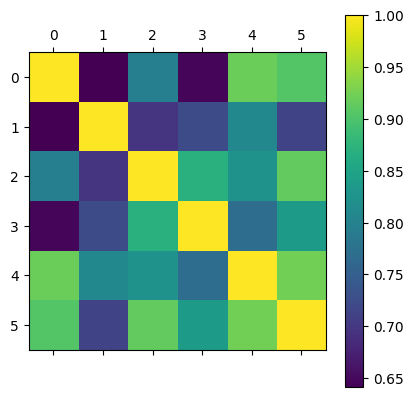

In [26]:
plt.matshow(final_data[numeric_columns].corr())
plt.colorbar()


In order to predict upcoming games, it would be good to drop total_reviews, played and playing - these will not be applicable to upcoming games. 

total_lists correlates highly with all features - for simplicity we will run the model with only this feature.

## Ratings_ correlaton check

Checking the ratings_ columns to see if they are useful

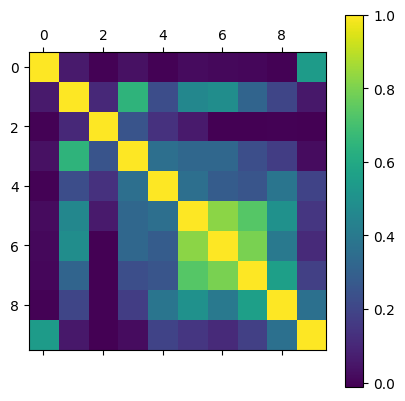

In [27]:
# Creating ratings columns
ratings_columns = ['ratings_zero_five',
       'ratings_one_zero', 'ratings_one_five', 'ratings_two_zero',
       'ratings_two_five', 'ratings_three_zero', 'ratings_three_five',
       'ratings_four_zero', 'ratings_four_five', 'ratings_five_zero']

# Filtering for only upcoming games
upcoming_mask_final_data = final_data['release_date'] > pd.Timestamp(datetime.date.today())
final_upcoming_games = final_data[upcoming_mask_final_data]

plt.matshow(final_upcoming_games[ratings_columns].corr())
plt.colorbar()


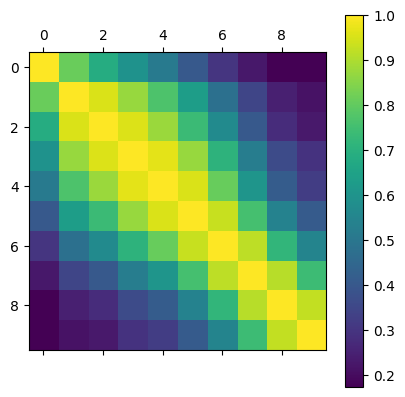

In [28]:
# Comparing to corrlelation of all games
plt.matshow(final_data[ratings_columns].corr())
plt.colorbar()


The ratings_ features could have been great for recomending current games - but we would have only used 0.5 and 5 star reviews as features, as they are the least correlated with each other. 

However, this feature should be missing for upcoming games, and will be excluded for now. 

NOTE: some unreleased games have ratings, so we assume its from a bug on Backlogged

### Categorical Data

In [29]:
categorical_columns = ['developers', 'genres', 'platforms']


In [30]:
# Encoding the category
mlb_devs = MultiLabelBinarizer()
transformed_devs = mlb_devs.fit_transform(final_data['developers'])

# Creating and sorting dataframe
dev_ohe_colums = pd.DataFrame(transformed_devs, columns=mlb_devs.classes_)
popular_devs = pd.DataFrame(dev_ohe_colums.sum().sort_values(ascending=False))
popular_devs.head(50)


,0
,6022
Nintendo,826
Sega,617
Konami,591
Sony Computer Entertainment,471
Electronic Arts,449
Capcom,445
Inc.,360
Activision,358
Square Enix,351


In [31]:
# Encoding the category
mlb_plats = MultiLabelBinarizer()
transformed_plats = mlb_plats.fit_transform(final_data['platforms'])

# Creating and sorting dataframe
plats_ohe_colums = pd.DataFrame(transformed_plats, columns=mlb_plats.classes_)
popular_plats = pd.DataFrame(plats_ohe_colums.sum().sort_values(ascending=False))
popular_plats.head(25)


,0
Windows PC,21441
Mac,6695
PlayStation 4,5322
Nintendo Switch,5151
Xbox One,4328
Linux,4005
iOS,3935
Android,3316
PlayStation 3,2052
PlayStation 2,1936


In [32]:
# Encoding the category
mlb_genre = MultiLabelBinarizer()
transformed_genre = mlb_genre.fit_transform(final_data['genres'])

# Creating and sorting dataframe
genre_ohe_colums = pd.DataFrame(transformed_genre, columns=mlb_genre.classes_)
popular_genre = pd.DataFrame(genre_ohe_colums.sum().sort_values(ascending=False))
popular_genre.head(25)


,0
Adventure,13603
Indie,11973
RPG,6543
Simulator,5778
Puzzle,5548
Strategy,5302
Shooter,5282
Platform,4672
Arcade,4135
Sport,2792


Developers and platforms will create clustrers in our recommendation model that are too similar. 

Genre works well, as games can have multiple which could create more divers clusters. We will use all 25 for the baselne model then itterate from there

In [33]:
final_data.columns


Index(['title', 'release_date', 'plays', 'playing', 'backlogs', 'wishlist',
       'developers', 'avg_review', 'genres', 'platforms', 'description',
       'total_reviews', 'total_lists', 'main', 'ratings_zero_five',
       'ratings_one_zero', 'ratings_one_five', 'ratings_two_zero',
       'ratings_two_five', 'ratings_three_zero', 'ratings_three_five',
       'ratings_four_zero', 'ratings_four_five', 'ratings_five_zero', 'url',
       'game_id'],
      dtype='object')

In [34]:
#Save Data as JSON
final_data.to_json("../raw_data/final_data", orient='records')


# Conclusion summary

## Features to use in model
### Numeric
- total_lists
- avg_review - target

### Categorical
- genres - one hot encoded

## Features to use in filtering
- release_date
- platforms
- genres

## Features to ignore, and why
- title - no value
- plays, playing, backlogs, total_reviews, ratings_* - these three features are only for released games and will throw bias unreleased games into their own cluster
- developers - no value
- description - no value, but considering NLP after baseline for more precise genres
- main - no value, as only indicates the main game
- url + game_id - no value for model. game_id will help us get more data from an API